# Classify Indian food

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
F = pd.read_csv('data/indian_food.csv')

In [3]:
F.head()

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45,25,sweet,dessert,West Bengal,East
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80,30,sweet,dessert,Rajasthan,West
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15,60,sweet,dessert,Punjab,North
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15,30,sweet,dessert,Rajasthan,West
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15,40,sweet,dessert,West Bengal,East


## Predict diet

In [5]:
target = F.diet.values
data = [x.lower().split(', ') for x in F.ingredients.values]

In [6]:
print(data[0], target[0])

['maida flour', 'yogurt', 'oil', 'sugar'] vegetarian


## Indexing dishes

In [7]:
from collections import defaultdict

In [10]:
I = defaultdict(lambda: defaultdict(lambda: 0))
for i, dish in enumerate(data):
    for ingredient in dish:
        I[i][ingredient] += 1
I = pd.DataFrame(I).T
I.fillna(0, inplace=True)

In [11]:
I.head()

,maida flour,yogurt,oil,sugar,gram flour,ghee,carrots,milk,cashews,raisins,...,soaked rice,cardamom pods,red pepper,watercress,glutinous rice,egg yolks,dry dates,dried rose petals,arrowroot powder,ginger powder
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Introduzione all'apprendimento supervisionato: Naive Bayes (from scratch)

In un contesto di apprendimento supervisionato siamo in possesso di un set (*training set*) di esempi pre-classificati. Il principio base dell'apprendimento supervisionato consiste nello sfruttare l'informazione fornita dal training set per evincere un criterio di classificazione da usare su dati non ancora classificati.

Nel caso di Naive Bayes, ciò è fatto con un ragionamento di tipo probabilistico. Guardando alla distribuzione delle feature nelle diverse classi dell'esempio siamo in grado di stimare infatti la probabilità di osservare una certa feature (un ingrediente nel nostro esempio) conoscendo la classe della ricetta.

$$P(feature \mid class) = P(ingrediente \mid dieta) \approx \frac{count(feature)}{\sum\limits_{i=0}^{n} count(feature_i)}$$

### Creazione del training set

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(I, target, test_size=0.33, random_state=42)

### Istanze delle classi nel training set

In [18]:
classes = {}
for c in set(target):
    cpos = [i for i, x in enumerate(y_train) if x == c]
    classes[c] = X_train.iloc[cpos]

In [31]:
def p_f_c(classes, X_train):
    P = defaultdict(lambda: defaultdict(lambda: 0))
    for feature in X_train.columns:
        for c, data in classes.items():
            count_feature = data[feature].sum()
            P[c][feature] = count_feature / data.sum().sum()
    return P

In [32]:
f_prob = p_f_c(classes, X_train)

In [37]:
print(f_prob['vegetarian']['carrots'])
print(f_prob['vegetarian']['lamb'])
print(f_prob['non vegetarian']['carrots'])
print(f_prob['non vegetarian']['lamb'])

0.0015552099533437014
0.0
0.0
0.009433962264150943


Il nostro problema però è in qualche modo l'inverso di stimare la feature data la classe perchè quando dovremo classificare i dati osserveremo solo le feature e sarà nostro compito stimare la classe. Perciò il nostro obiettivo è invertire la predizione $P(feature \mid class)$.

**Bayes' rule**
$$
P(A \mid B) = \frac{P(A)P(B \mid A)}{P(B)}
$$

applicato al nostro caso diventa

$$
P(class \mid feature) = \frac{P(class)P(feature \mid class)}{P(feature)} \approx P(class)P(feature \mid class)
$$

Nell'osservare un dato che ha più feature caratteristiche, se assumiamo che le feature siano fra loro tutte indipendenti, allora possiamo generalizzare come segue

$$
P(class \mid feature) \approx P(class)\prod\limits_{i=1}^{n} P(feature_i \mid class)
$$

Semplificando, l'idea è riassumibile come:

$$
\textsf{POSTERIOR is proportional to PRIOR times LIKELIHOOD}
$$

### Likelihood di un item data una classe

In [39]:
item = data[0]
c = 'non vegetarian'

In [40]:
print(item)
print([f_prob[c][x] for x in item])

['maida flour', 'yogurt', 'oil', 'sugar']
[0.0, 0.009433962264150943, 0.0, 0.009433962264150943]


### Probabilità nulle
Dato che per stimare la likelihood considereremo il prodotto delle probabilità delle singole feature, una sola feature assente nella classe considerata annullerà l'intera stima. Per far ciò si ricorre a uno pseudo conteggio noto come *Laplace smoothing* nel quale aggiungiamo una quantità $\alpha > 0$ a tutti i conteggi.

In [49]:
def p_f_c_a(classes, X_train, alpha=0.1):
    P = defaultdict(lambda: defaultdict(lambda: 0))
    for feature in X_train.columns:
        for c, data in classes.items():
            count_feature = data[feature].sum() + alpha
            P[c][feature] = count_feature / (data.sum().sum() + alpha * data.shape[0])
    return P

In [54]:
f_prob_a = p_f_c_a(classes, X_train, alpha=0.1)

In [55]:
print(item)
print([f_prob_a[c][x] for x in item])

['maida flour', 'yogurt', 'oil', 'sugar']
[0.0009250693802035154, 0.01017576318223867, 0.0009250693802035154, 0.01017576318223867]


In [56]:
likelihood = lambda item, c: np.prod([f_prob_a[c][x] for x in item])    

In [57]:
print(likelihood(item, 'vegetarian'))
print(likelihood(item, 'non vegetarian'))

1.3698210438052818e-08
8.860997101649301e-11


### Prior
Per stimare i prior delle classi possiamo semplicemente utilizzare la loro numerosità

In [58]:
priors = dict([(c, k.shape[0] / X_train.shape[0]) for c, k in classes.items()])

In [59]:
priors

{'non vegetarian': 0.12352941176470589, 'vegetarian': 0.8764705882352941}

### Prediction

In [60]:
def predict(item, targets):
    probs = np.array([priors[c] * likelihood(item, c) for c in targets])
    guess = targets[np.argmax(probs)]
    return guess, probs

In [65]:
list(set(target))

['non vegetarian', 'vegetarian']

In [66]:
predict(item, list(set(target)))

('vegetarian', array([1.09459376e-11, 1.20060786e-08]))

### Visualize

In [69]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [73]:
target_values = list(set(target))

In [70]:
pca = PCA(n_components=2)
Vx = pca.fit_transform(X_train)
Vt = pca.transform(X_test)

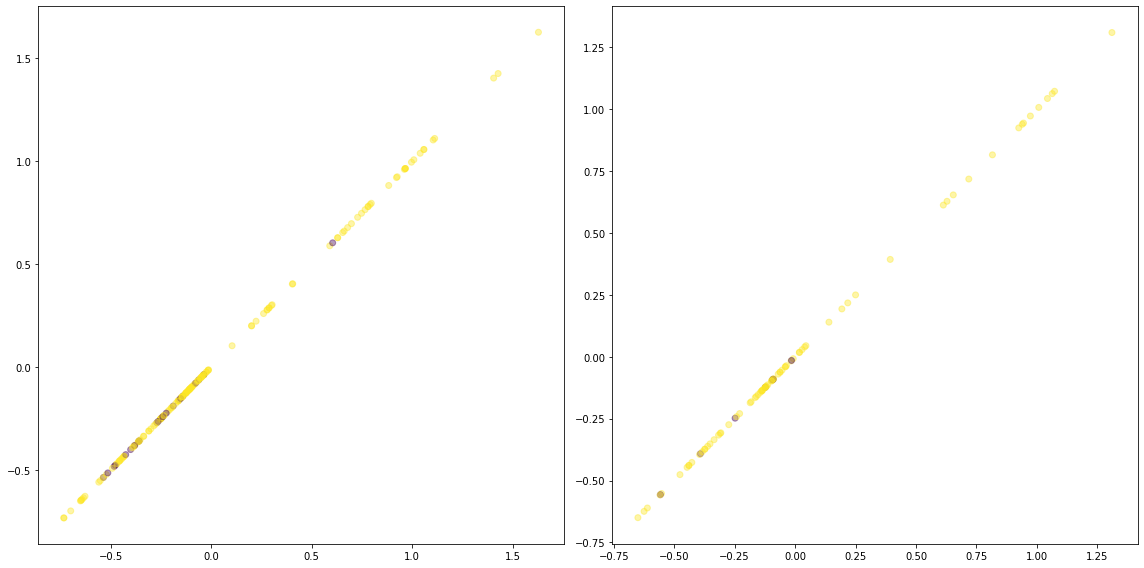

In [75]:
fig, ax = plt.subplots(figsize=(16, 8), ncols=2)
ax[0].scatter(Vx[:,0], Vx[:,0], c=[target_values.index(v) for v in y_train], alpha=0.4)
ax[1].scatter(Vt[:,0], Vt[:,0], c=[target_values.index(v) for v in y_test], alpha=0.4)
plt.tight_layout()
plt.show()

### Evaluate

In [80]:
import sklearn.metrics as mt

In [76]:
test_data = [data[i] for i in X_test.index.values]

In [78]:
y_pred = [predict(item, target_values)[0] for item in test_data]

In [81]:
print(mt.classification_report(y_test, y_pred))

                precision    recall  f1-score   support

non vegetarian       0.29      0.88      0.44         8
    vegetarian       0.98      0.78      0.87        77

      accuracy                           0.79        85
     macro avg       0.64      0.83      0.65        85
  weighted avg       0.92      0.79      0.83        85



In [82]:
cm = mt.confusion_matrix(y_test, y_pred)
plot = mt.ConfusionMatrixDisplay(cm)

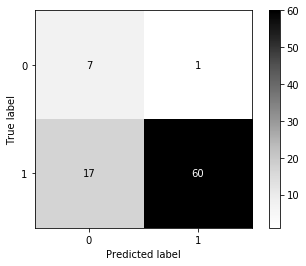

In [84]:
plot.plot(cmap='Greys')
plt.show()

### Approfondimento
- Provare a usare un diverso target di classificazione come ad esempio i campi `course` o `region`
- Utilizzare l'implementazione [sklearn di GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

In [85]:
F.course.unique()

array(['dessert', 'main course', 'starter', 'snack'], dtype=object)

In [86]:
F.region.unique()

array(['East', 'West', 'North', '-1', 'North East', 'South', 'Central',
       nan], dtype=object)